<h1><center>A Simple Named Entity Recognition Model using  BERT  and Keras </center></h1>
    
<h2><center>    (And Another Simple One Using T5)</center></h2>
<h4><center>Initially prepared for UC Berkeley MIDS - W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook we investigate how we can leverage **BERT** (see ["BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"](https://arxiv.org/pdf/1810.04805.pdf), by Devlin/Chang/Lee/Toutanova, Google AI Language) for the problem of Named Entity Recognition (NER). Their paper actually contains the NER use case as a fine-tuning example, but we are not striving to replicate necessarily exactly their approach but build the model in the most approachable and 'naive' way, i.e. simply applying a straightforward model that follows intuitively the BERT mantra leveraging its context-based embeddings.


We look at the effect of also fine-tuning BERT layers vs just adding and training classification layers on top of the BERT model and find that in this cursory and certainly incomplete study the re-training of BERT layers does offer some advantages. We also perform a test reducing the training data by 90% and find that the results are still quite decent, re-emphasizing BERT's usefulness in situations where the data set is on the small side. 

**Update:** In the appendix, we also recast the NER problem as a 'translation problem', allowing us to also get some practice with **T5** ["Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer"](https://arxiv.org/pdf/1910.10683.pdf) , by C. Raffel et al. (Note that one likely would expect less favorable results for the specific NER problem, but the introduction of T5 is the purpose, not the actual result.)


## Table of Contents

I. [Introduction & Approach](#ia)   
1. [Introduction](#intro)  
2. [Problem Definition & Metrics](#problem)  
3. [Notebook Strategy](#strategy)  


II. [Setup](#setup)   
1. [Data](#data)  
2. [BERT](#bert)  
3. [Getting Started](#start)  


III. [Data Preprocessing](#preprocess)   
1. [BERT Tokenizer & BERT as a Black Box](#tokenizer)  
2. [Input Generation](#extract)  
3. [Initial Data Analysis](#analysis) 
4. [Baseline: Always picking 'Other'](#baseline) 
5. [Train/Test Split](#split)  

IV. [The Model](#model)   
1. [Custom Loss & Accuracy](#custom)  
2. [BERT Layer](#bert_layer)  
2. [Model Construction](#ner_model) 


V. [Model Runs/Experiments](#runs)   
1. [With BERT-layer Fine-Tuning](#retrain)  
2. [Predictions & Confusion Matrix](#confusion)  
3. [Without BERT-Layer Fine-Tuning](#basic)  
4. [A 90%-Reduced Training Set](#tiny)  


VI. [Summary](#summary)  

Appendix: [T5](#T5)  



## I. Introduction & Approach <a id="ia" />

### I. Introduction & Strategy <a id="intro" />

BERT and other context-aware embedding frameworks like [ELMO](https://arxiv.org/abs/1802.05365), OpenAI's [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), and [XLNet](https://arxiv.org/pdf/1906.08237.pdf), etc.  -  provide extremely useful basis for many NLP tasks. A key reason why these frameworks are so useful is that they allow us to use the power of extensive pre-training that was done on a (set of) large corpus/era. 

More specifically, their ability to encode deep contextual relationships between words (and sentences or sentence segments) derived from a generic set of tasks provides us with the context-specific embeddings.  Depending on the task, we can then simply add a couple of classification layers with a modest number of weights to fine-tune the combined model to our very specific NLP task that may not have the luxury of a very large labeled data set.

There are numerous and very good resources available on the web for various of these tasks (Movie Reviews, Sentiment  Analysis, etc,.). In this notebook, we want to consider the task of Named Entity Recognition, as it features a number of useful complexities that are good to discuss:

* token-level vs. sentence-level BERT output, which seems to be less-often discussed 
* potential one-to-many split of word-to-token by the tokenizer (what are we going to do for the labels?) 
* potentially a need for custom loss and accuracy definitions

Conceptually, we will follow the original BERT paper in its approach to NER:

<img src="BERT_NER_Devlin_et_al.png" alt="Drawing" style="width: 600px;"/>
<center>Image Source: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"</center>

Each word will need to be tokenized. We will then, sentence-by-sentence, feed in the tokenized text into BERT, resulting in our case (we are using the BERT's base model) in a 768-dimensional output vector for each input token (and other tokens that BERT wants us to add). We then simply add a fully-connected hidden layer and finally a classification of suitable dimension that will take each token-output and make a decision on its NER label.  


This is very intuitive. However, a few obvious questions arise that we want to look at in this notebook:

1) How do we need to pre-process the data set to be suitable for BERT?   
3) How can we build the model in Keras?   
4) How can we incorporate custom loss functions and accuracy calculations?   
5) What does fine-tuning mean? Is it just adding and training new layer(s), or do I re-train BERT layers as well?   
6) Do I need to worry about customizing the optimizer?  

These and other questions we hope to be able to shed some light on. The dataset we will be using is the "**Annotated Corpus for Named Entity Recognition using GMB [Groningen Meaning Bank]**", which is shared on [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). It contains sentences with 1m+ words, conveniently annotated with POS and NER tags. 

### I.2. Problem Definition & Metrics <a id="problem" />

Our task will obviously be to properly identify the NER tags. There are potentially two things to consider when we want to define our success metrics: 

1) If we send the data sentence-by-sentence, we will need to apply padding to ensure consistent length. This will create 'new' labels that we will call 'nerPad'. Also, words can be split into multiple tokens, requiring us to add filler labels, which we will denote 'nerX'.  (There are multiple ways to address this, but this is what we are choosing here.)

If we do that, should we look at accuracy over all tokens? Probably not. So our **first metric will be: accuracy for tokens which were part of the original text (and only the first token if a word is split)**.

2) As we know from NER problems, most tokens will be 'Other'. So we may get already a pretty decent baseline result by always predicting 'Other'. In situations like that it may be useful to also look at **our second metric: the accuracy for all original tokens that are not 'Other'**.


### I.3. Notebook Strategy <a id="strategy" />

The outline that we will follow in this notebook is this:

**1) Process the text**
* re-assemble words into sentences. (The corpus is of the form one-line-one-word, with sentence markers.)
* tokenize the sentences with the BERT Tokenizer
* create the input ids required for BERT:
   * **sentence_ids** [the list of token ids for each sentence]
   * **mask_ids** [the specification whether a specific token should be masked out (we mask out '[PAD]' tokens)]
   * **sequence_ids** [used to denote whether a token is part of the first, second, or other segment in each input example. For us, this will always be '0'.]
* prepare the labels  

Some complications can include:
- some words may not be in vocab
- words can get split into multiple tokens. What are the labels?
- Sentences do not all have the same length. Padding!
- usual formatting details, like "10,000" and """ for quotes in this case.

**2) Analyze and prepare the data**
* Identify balance/imbalance situation
* Estimate baseline accuracy defined by 'always picking the most common token'
* Split into training and test set

**3) Build the model**
* Build BERT layer
* Add classification layer(s)
* Define custom loss functions and metrics

**4) Run a few experiments**
* Allow for re-training of a few BERT layers
* Investigate the confusion matrix
* Compare results with the model without re-training BERT layers
* Test how good the results would be if you only at 10% of the training data (~4k sentences) 

**Appendix: Try the NER task witgh T5**
* Re-phrase NER problem as a translation problem (maybe not natural... but why not?) 
* Create training/test data
* Run a test  

This notebook leverages BERT and T5 implementations from Hugging Face.  

The notebook was run with **Tensorflow 2.3** and **Transformers 4.0.0**, leveraging one GPU with 4 GB of memory. (Note that I ran out of GPU memory a couple of times and restarted appropriately. But other than that with the given versions the notebook should execute end-to-end.)



## II. Setup & Strategy

### II.1. Data<a id="data" />

First, obtain the dataset ("**Annotated Corpus for Named Entity Recognition using GMB [Groningen Meaning Bank]**", which is shared on [Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus). The ner_dataset.csv file is the relevant file.

Let us take a quick peek at the file:


In [1]:
!tail -20 'ner_dataset.csv'

We see the words line-by-line, the labels (POS and NER), and the sentence boundaries. Perfect.

### II.2. Environment & Imports:  <a id="bert" />

First off, here are the versions of key libraries that need to be installed. (Obviously, newer versions generally are expected to work, but these versions were used in the notebook.)

In [2]:
!pip freeze | grep tensorflow
!pip freeze | grep sentencepiece
!pip freeze | grep transformers

tensorflow==2.3.0
tensorflow-estimator==2.3.0
sentencepiece==0.1.95
transformers==4.0.0


In [3]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

from datetime import datetime

from collections import defaultdict

import sentencepiece



In [4]:
tf.get_logger().setLevel("ERROR") 

BERT and T5 are easily imported from **Hugging Face's transformer library** (https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel, etc.):

In [5]:
from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration

(For now we will only work with the BERT components. More on T5 in the appendix.)

So the two components we need are the **model** and the **tokenizer**.

Define some key parameters:

In [6]:
data_path = './'  # path to ner_dataset.csv file , from 

now = datetime.now() # curren

def custom_acc_orig_non_other_tokens(y_true, y_pred):

    """

    calculate loss dfunction explicitly filtering out also the 'Other'- labels

    

    y_true: Shape: (batch x (max_length) )

    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 

    

    returns: accuracy

    """



    #get labels and predictions

    

    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])


# make sure that the paths are accessible within the notebook
sys.path.insert(0,data_path)

Obviously, we will need to do quite a bit of pre-processing. BERT - as well as NER in general - requires us to process the text in a larger context, which suggests that we should send the data to BERT sentence-by-sentence. (An alternative would also be to just chunk up the text, irrespective of sentence boundaries.)

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer & BERT as a Black Box<a id="tokenizer" />

We need to define the tokenizer. BERT has its own and that is the one that should be used. As it is specific to the (pre-trained) model, we need to specify it. For obvious reasons we will use the 'cased'  model. 

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Let's play with the tokenizer. You will see that the tokenizer occasionally splits one word into multiple tokens. Why is that the case? Because the approach of using word pieces reduces the vocabulary size and/or number of unknown words.

Here is one example:

In [9]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

In [10]:
tokenizer.tokenize('This sentence is simple and uses a nice dataset')

['This',
 'sentence',
 'is',
 'simple',
 'and',
 'uses',
 'a',
 'nice',
 'data',
 '##set']

In [11]:
tokenizer.encode('this is easy')

[101, 1142, 1110, 3123, 102]

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [12]:
tokenizer.convert_tokens_to_ids([
    '[CLS]', 'this', 'is', 'easy', '[SEP]'])

[101, 1142, 1110, 3123, 102]

In [13]:
tokenizer.convert_ids_to_tokens([1234])

['people']

Good. Now we are ready to use it for our text. 

But before we generate the model input data, let us first highlight also the BERT basics.

We start by defining a BERT model that is created from one of the pre-trained models:

In [14]:
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.layers

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Next, let us look at the weights in 'the' main layer. There are actually many layers in BERT. It starts with its own embeddings and goes through various other layers (discussed in detail in next week's live sessions):

In [53]:
len(bert.layers[0].weights)

199

Off.. that's a lot of 'layers'. Let's look at the names and dimensions of the first 11 layers:

In [78]:
for layer in range(11):
    print(layer)
    print('Layer name: \t', bert.layers[0].weights[layer].name)
    print('Layer shape: \t', bert.layers[0].weights[layer].shape)

0
Layer name: 	 tf_bert_model/bert/embeddings/word_embeddings/weight:0
Layer shape: 	 (28996, 768)
1
Layer name: 	 tf_bert_model/bert/embeddings/position_embeddings/embeddings:0
Layer shape: 	 (512, 768)
2
Layer name: 	 tf_bert_model/bert/embeddings/token_type_embeddings/embeddings:0
Layer shape: 	 (2, 768)
3
Layer name: 	 tf_bert_model/bert/embeddings/LayerNorm/gamma:0
Layer shape: 	 (768,)
4
Layer name: 	 tf_bert_model/bert/embeddings/LayerNorm/beta:0
Layer shape: 	 (768,)
5
Layer name: 	 tf_bert_model/bert/encoder/layer_._0/attention/self/query/kernel:0
Layer shape: 	 (768, 768)
6
Layer name: 	 tf_bert_model/bert/encoder/layer_._0/attention/self/query/bias:0
Layer shape: 	 (768,)
7
Layer name: 	 tf_bert_model/bert/encoder/layer_._0/attention/self/key/kernel:0
Layer shape: 	 (768, 768)
8
Layer name: 	 tf_bert_model/bert/encoder/layer_._0/attention/self/key/bias:0
Layer shape: 	 (768,)
9
Layer name: 	 tf_bert_model/bert/encoder/layer_._0/attention/self/value/kernel:0
Layer shape: 	 (7

Let's point out a few observations:

 * We see the embedding layer which maps the token id to a 768 dim vector 
 * Next is the positional encoding which encodes the 512 BERT input positions. looks right.
 * Layers 5-10 hold the weights and biases for the first self-attention layer
 
So this all seems consistent and as expected.

With the BERT model available, let us create a sample input and then look at the BERT output.

BERT has various inputs, but most of them optional (see: https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel). The minimum input are the input ids that should be of shape 'batch size' x 'sequence length'. (Note that in the text further down we will actually construct other inputs as well to be maximally explicit).

Here is the proper input of our sample sentence:

In [16]:
input_ids = np.array([tokenizer.encode('I am very happy today. [PAD] [PAD] [PAD]')])
input_ids

array([[ 101,  146, 1821, 1304, 2816, 2052,  119,    0,    0,    0,  102]])

In [17]:
tokenizer.convert_ids_to_tokens([2816])

['happy']

In [18]:
input_ids.shape

(1, 11)

That looks right: batch size 1, and length is 13. Now let's look at the bert output for this input. We follow here the Functional API way of thinking as 'output = layer(input)'

In [19]:
bert_output = bert(input_ids)
len(bert_output)

2

So there are 2 outputs. What are their shapes and interpretation?

In [22]:
bert_output[0].shape

TensorShape([1, 11, 768])

This first output with dimension 'batch size' x 'length' x 768 are the 768 dimensional **context-based embeddings** of each input token! These are what will replace the traditional word embeddings.

Let's look at the output vector for the word happy:

In [52]:
happy_vec = bert_output[0][0, 4]
happy_vec[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.12506872, -0.05962533,  0.06276665, -0.09036952, -0.11729954,
        0.00508372,  0.09644235, -0.11545931, -0.23156177, -0.02102023,
        0.05975365,  0.44875303, -0.06902964,  0.34377128, -0.6355732 ,
        0.2495417 , -0.1861915 , -0.28699917,  0.2895734 , -0.14723203],
      dtype=float32)>

What is the second BERT output?

In [23]:
bert_output[1].shape

TensorShape([1, 768])

The second output is the 'pooler output', which is the output of the CLS token, followed by another linear classification with tanh activation.

Now, where we understand the tokernizer and the 'black box basics' of BERT, we are ready to work on our data.

### III.3. Input Generation<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

In [38]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [39]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [40]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': 1}

In [41]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

We are now ready to convert the text file into appropriate arrays. First, we need to define the length of each example. For this we will define the hyper-parameter max_length. All sentences longer (post-tokenization!) than this parameter will be clipped off, and all sentences that are shorter will be padded.

In [42]:
max_length = 30

Example creation:

In [43]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open(data_path + 'ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    sent, word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (sent[:8] == 'Sentence'):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word

    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

What did this do?

In [44]:
print(sentenceTokenList[2])

['[CLS]', 'They', 'marched', 'from', 'the', 'Houses', 'of', 'Parliament', 'to', 'a', 'rally', 'in', 'Hyde', 'Park', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [45]:
print(nerTokenList[2])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [46]:
print(bertMasks[2])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [47]:
print(bertSequenceIDs[2])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([1.0000e+00, 2.0000e+00, 3.0000e+00, 1.9000e+01, 1.0600e+02,
        1.8400e+02, 3.0800e+02, 4.3000e+02, 5.1900e+02, 6.6700e+02,
        8.2800e+02, 9.4000e+02, 1.0040e+03, 1.1560e+03, 1.2590e+03,
        1.3620e+03, 1.4480e+03, 1.5610e+03, 1.5710e+03, 1.7080e+03,
        1.7600e+03, 1.8350e+03, 1.9350e+03, 1.9450e+03, 1.9120e+03,
        1.8550e+03, 1.9040e+03, 1.9736e+04]),
 array([ 2.        ,  2.96428571,  3.92857143,  4.89285714,  5.85714286,
         6.82142857,  7.78571429,  8.75      ,  9.71428571, 10.67857143,
        11.64285714, 12.60714286, 13.57142857, 14.53571429, 15.5       ,
        16.46428571, 17.42857143, 18.39285714, 19.35714286, 20.32142857,
        21.28571429, 22.25      , 23.21428571, 24.17857143, 25.14285714,
        26.10714286, 27.07142857, 28.03571429, 29.        ]),
 <BarContainer object of 28 artists>)

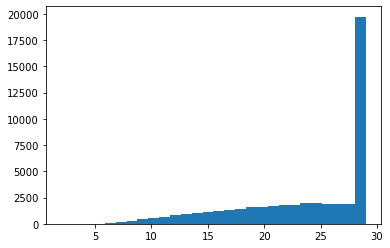

In [48]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

An average sentence length of ~25 (incl. extra tokens!) is roughly expected. It turns out that on these types of corpora an average sentence length of ~20 tends to be seen. The big spike on the right obviously corresponds to all sentences that we had to truncate. 

Next, we analyze the distribution of ner labels. First, we assign numbers to the labels and look at the overall distribution:

In [49]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<AxesSubplot:title={'center':'cat'}>]], dtype=object)

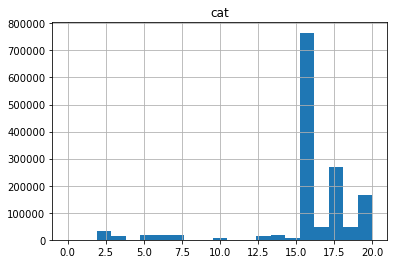

In [50]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 16+... Let's see which labels these label numbers corresponds to:

In [51]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-art,0,345
1,B-art,1,0
2,B-art,2,0
3,B-art,3,0
4,B-art,4,0
...,...,...,...
436,nerX,16,0
437,nerX,17,0
438,nerX,18,0
439,nerX,19,0


Interesting. 16 corresponds to 'O', and all 'extension' labels (i.e., those that were not part of the original data) occur at 17+. 

'O' is the most common token - by far.

### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [52]:
O_occurences = int(nerDistribution.loc[nerDistribution.tag == 'O','occurences']\
                                .reset_index().drop(['index'], axis=1).loc[16])   # Some gymnasics to get the count..
All_occurences = nerDistribution[nerDistribution.cat < 17]['occurences'].sum()

O_occurences/All_occurences

0.8432003701378102

So **84.3%** is the baseline to beat for our first metric! Can we do that? We'll see.

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [53]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

We now split - in a pretty manual way - the examples into a train and test set. We create a random binary value for each sentence that we use to split train and test data.

In [54]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)

In [55]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

nerLabels_train =[]
nerLabels_test = []


for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        nerLabels_train.append(nerLabels[example])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        nerLabels_test.append(nerLabels[example])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_test = np.array(nerLabels_test)

In [56]:
X_train[0,0]

array([  101, 26159,  1104,  8568,  4487,  5067,  1138,  9639,  1194,
        1498,  1106,  5641,  1103,  1594,  1107,  5008,  1105,  4555,
        1103, 10602,  1104,  1418,  2830,  1121,  1115,  1583,   119,
         102,     0,     0])

In [57]:
nerLabels_train[0]

array([17, 16, 16, 16, 20, 20, 16, 16, 16,  2, 16, 16, 16, 16, 16,  2, 16,
       16, 16, 16, 16,  3, 16, 16, 16, 16, 16, 19, 18, 18], dtype=int8)

In [58]:
print(sentenceTokenList[0])

['[CLS]', 'Thousands', 'of', 'demons', '##tra', '##tors', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', '[SEP]', '[PAD]', '[PAD]']


Let's also get a few train/test positions:

In [59]:
training_examples[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In the last step, we prepare the actual train and test input and label data. For convenience (quick functionality test on small data set), we introduce parameters k_start & k_end to just use a slide of the full dataset. (Setting k_end to -1 corresponds to using the whole set (as we will do in the following). 

In [60]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [61]:
train_all = [bert_inputs_train_k, labels_train_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [62]:
with open(r"./bert_train_data.pickle", "wb") as output_file:
    pickle.dump(train_all, output_file)
    
with open(r"./bert_test_data.pickle", "wb") as output_file:
    pickle.dump(test_all, output_file)

In [24]:
with open(r"./bert_train_data.pickle", "rb") as input_file:
    bert_inputs_train_k, labels_train_k = train_all = pickle.load(input_file)
    
with open(r"./bert_test_data.pickle", "rb") as input_file:
    bert_inputs_test_k, labels_test_k = test_all = pickle.load(input_file)

In [25]:
numNerClasses = 21  # for fast restart w/o the need to recreate data
numSentences = 47958

#X_train = np.array(train_all[0])
#Y_train = np.array(train_all[0])

That's it. We are all set to go.

## IV. The Model<a id="model"/>

### IV.1. Custom Loss & Accuracy<a id="custom"/>

We need a **custom loss function** because we only want to optimize for the labels that we actually had in the text, not the extra ones like '[nerPAD]', etc. Our cost function is therefore derived from sparse_categorical_crossentropy, but we choose to modify the function a bit:  we want to mask out all tokens that have a token id larger or equal of 17, corresponding to the extra tokens:  

In [25]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label < 17)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))


Does it work as advertised? Let's create a toy example:

In [27]:
y_true = tf.constant([[17],[0]])

y_pred = tf.constant([
    [0.0,0,0,0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])


# Nice to have eager execution now...

print(custom_loss(y_true, y_pred))



tf.Tensor(0.5108275, shape=(), dtype=float32)


Compare this to the manual calculation of $-\log((y^1_{pred})_0)$ (remember that $y^0$ is masked out because the true label is 17) 

In [28]:
-np.log(0.6)

0.5108256237659907

So this is correct! The position where the true label is 17 is ignored because of the mask!

In a similar vein, we define and test a **custom accuracy** calculation:

In [29]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 17)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

Let us also define another accuracy calculation that only looks at the non-Other labels: 

In [30]:
def custom_acc_orig_non_other_tokens(y_true, y_pred):
    """
    calculate loss dfunction explicitly filtering out also the 'Other'- labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label < 16)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [31]:
y_true = tf.constant([[17],[0]])

y_pred = tf.constant([
    [0.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.4,0,0,0],
    [0.6,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])


print(custom_acc_orig_tokens(y_true, y_pred))


tf.Tensor(1.0, shape=(), dtype=float64)


Again... correct! The false value for the '17' example is not considered.


Lastly, define an Adam optimizer with new learning rate and beta parameters:

In [32]:
adam_customized = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

Next, we define the summary statistics for TensorBoard. And then we can construct the model.

### IV.2 Model Construction<a id="ner_model"/>

Time to build the model! Let's be pretty simple. No drop-out etc for now. But we re-train three BERT layers.

In [33]:
def ner_model(max_input_length, train_layers, optimizer):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    
    
    # Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
    # the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 
    
    bert_layer = TFBertModel.from_pretrained('bert-base-cased')
    
    # Freeze layers, i.e. only train number of layers specified, starting from the top
    
    if not train_layers == -1:
        
        retrain_layers = []
    
        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_layer.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(bert_inputs)[0]
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(21, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens, 
                                                          custom_acc_orig_non_other_tokens])
    
    
    model.summary()
    
    return model


## V. Model Runs/Experiments<a id="runs"/>

### V.1. With BERT-Layer Re-Training<a id="retrain"/>

It is time to run the first test.

In [34]:
bert_inputs_train_k[0][0]

array([  101, 26159,  1104,  8568,  4487,  5067,  1138,  9639,  1194,
        1498,  1106,  5641,  1103,  1594,  1107,  5008,  1105,  4555,
        1103, 10602,  1104,  1418,  2830,  1121,  1115,  1583,   119,
         102,     0,     0])

In [35]:
tf.keras.backend.clear_session()

Let us choose to retrain the all layers of BERT and then train the model:

In [62]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# retrain all layers
model = ner_model(max_length + 1, train_layers=-1, optimizer = adam_customized)

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k }),
    epochs=5,
    batch_size=16
)



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: Tensor("tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0", shape=(None, 30, 768), dtype=float32)
pred:  Tensor("ner/truediv:0", shape=(None, 30, 21), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
_______________________________________________

**97.0% test accuracy for all original tokens and 84.3% for all original 'non-Other' tokens.... Not bad!!** And some tweaking and tuning should probably increase the values a bit more.

Note that we used here the **Adam optimizer with custom values. Did that matter?** Why don't you try it...

### V.2. Predictions & Confusion Matrix<a id="confusion" />


Let us look and see how well the model performs. We use the test here. (It probably would be better to split the data into train/validation/test, we are somewhat casual here).

First, get all of the predictions for the test set:

In [63]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]

result = model.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [64]:
print(result.shape)

(14268, 30, 21)


This is the correct shape: # test sentences x sentence length x # classes. 
Let's get the prediction argmax for a random test sentence:

In [65]:
print(np.argmax(result, axis=2)[6])

[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  2 16 16 16  6 14 14 14
 14 16 16 16 16 16]


What were the labels?

In [66]:
print(nerLabels_test[6])

[17 16 20 20 16 20 16 16 16 16 16 16 16 16 16 16  2 16 20 16  6 14 20 14
 14 16 19 18 18 18]


**Wrong? Correct!** Or.. is it?  

**Question: Why are we not bothered by the first and the last 'mistakes', i.e., not identifying 20, 17, 19, 18, etc.?**

Let us now get the confusion matrix:

In [67]:
predictions_flat = [pred for preds in np.argmax(result, axis=2) for pred in preds]
labels_flat = [label for labels in nerLabels_test for label in labels]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label < 17:
        clean_preds.append(pred)
        clean_labels.append(label)


In [68]:
cm = tf.math.confusion_matrix(
    clean_labels,
    clean_preds,
    num_classes=None,
    dtype=tf.dtypes.int32,
    name=None,
    weights=None
)

Probably a little big and unbalanced to display. Let us focus on the rows/columns with the common labels:

In [69]:
np.sum(cm, axis=0)

array([     0,     27,  10376,   4205,      0,   4742,   4787,   5108,
            0,     14,   1785,     23,      0,   4248,   5096,   1355,
       227944])

In [70]:
cm_most = np.array(cm)[[2,3,5,6,7,13,14,16],:] [:, [2,3,5,6,7,13,14,16]]

print(cm_most)

[[  8845     60    298    132     23     29     55    245]
 [   211   3993     26      4      0      4      1     11]
 [   703     58   3755    246     12    104    100    398]
 [   160      1    159   4035      1     48    173    175]
 [    83      0     11      4   4628      4      4    376]
 [    76     14     87     59      1   3360    236    304]
 [     4      6     13    165      1    149   4319     36]
 [   167     53    319    125    312    302    127 225967]]


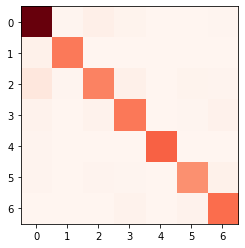

In [71]:
plt.imshow(cm_most[:-1,:-1], cmap='Reds')

Not bad!

### V.3 Without BERT-Layer Retraining ("Did fine-tuning of BERT layers help?")

We will re-run the model, but without re-training of the top BERT layer: 

In [72]:
tf.keras.backend.clear_session()

In [73]:
model = ner_model(max_length + 1,train_layers=0,optimizer='adam')

# Instantiate variables

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k}),
    epochs=8,
    batch_size=32
)



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: Tensor("tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0", shape=(None, 30, 768), dtype=float32)
pred:  Tensor("ner/truediv:0", shape=(None, 30, 21), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
_______________________________________________

**Somewhat close, but not quite as good.** - While one has to be careful given the different optimizer configurations and number of epochs, it looks as if not re-training BERT - in this case - increased the loss and reduced the accuracy a bit. Let's call this **~96.6%/81.6% accuracy** compared to 97.0%/84.3%. 

The relative benefit of fine-tuning BERT layers will depend on the problem.

**Side Notes:** 
 * Deeper re-training needs more compute resources
 * Deeper re-training sometimes requires a tuned optimizer
 * Regularization is definitely important...

### V.4. A 90%-Reduced Training Set<a id="tiny"/>


The claim is that BERT is also very useful if one doesn't have much data. So let us see what happens if we cut the training data down to 10%. That leaves us with only ~3400 training examples. Not much...

In [80]:
X_train.shape

(3, 33690, 30)

In [81]:
numTrainSentences = 3370

bert_inputs_train_tiny = [bert_inputs_train_k[0][:numTrainSentences,:], \
                          bert_inputs_train_k[1][:numTrainSentences,:], \
                          bert_inputs_train_k[2][:numTrainSentences,:]]

In [82]:
labels_train_tiny = labels_train_k[:numTrainSentences,:]

In [83]:
tf.keras.backend.clear_session()

Let us first train without BERT-layer fine-tuning:

In [78]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# retrain all layers
model = ner_model(max_length + 1,train_layers=0,optimizer='adam')

model.fit(
    bert_inputs_train_tiny, 
    {"ner": labels_train_tiny },
    epochs=5,
    batch_size=16
)
model.fit(
    bert_inputs_train_tiny, 
    {"ner": labels_train_tiny },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k}),
    epochs=1,
    batch_size=16
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: Tensor("tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0", shape=(None, 30, 768), dtype=float32)
pred:  Tensor("ner/truediv:0", shape=(None, 30, 21), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
_______________________________________________

Not too bad, one would think! **~95.3%/74.7%** on the test set, compared to ~96.6%/81.6% accuracy on the full training set (w/o BERT-layer re-training) with 1/10th of the data. So BERT embeddings are serving quite well for a smaller data set. 

At last, let us also compare this to the case where we retrain all BERT layers. This will shed light on the question whether retraining pays off relatively more when data is scarce.

In [84]:
tf.keras.backend.clear_session()

# retrain all layers
model = ner_model(max_length + 1,train_layers=-1,optimizer=adam_customized)

model.fit(
    bert_inputs_train_tiny, 
    {"ner": labels_train_tiny },
    epochs=5,
    batch_size=16
)

model.fit(
    bert_inputs_train_tiny, 
    {"ner": labels_train_tiny },
    validation_data=(bert_inputs_test_k, {"ner": labels_test_k}),
    epochs=1,
    batch_size=16
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: Tensor("tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0", shape=(None, 30, 768), dtype=float32)
pred:  Tensor("ner/truediv:0", shape=(None, 30, 21), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 30)]         0                                            
_______________________________________________

**96.2%/80.5%** on the reduced set, compared to 97.0%/84.3% test accuracy for all original tokens and for the full dataset (both with layer re-training). That is quite good - only a loss of about 0.8%-points/3.9%-points.

Compare that also to the results without layer retraining: ~95.3%/74.7% for the 1/10 data set vs ~96.6%/81.6%  for the full training set, corresponding to a 1.3%-points/6.9%-point reduction.

It appears that transfer-learning for small data sets may really benefit from layer re-training. Here is the summary table:


|Dataset         | Retrain Layers?           | Base Token Accuracy   | Base Token Accuracy w/o 'Other'   | Notes  |
| ------------- |:-------------:| :-------------:| :-------------:|-------------:|
| **Full**       | Yes (all) | **97.0%** | **84.3%** |custom Adam, 5 epochs|
| **Full**       | No      |   **96.6%** | **81.6%** |default Adam, 8 epochs|
| **1/10**  |  Yes (all)      |   **96.2%** | **80.5%** |custom Adam, 6 epochs|
| **1/10**  | No     |    **95.3%** | **74.7%**|default Adam, 6 epochs|


**Disclaimers/Cautions:**

* The models were generally not optimized and/or run for the optimal duration. Numbers of epochs are not consistent and were selected based on 'good-enough for now'-strategy.  Quite possibly some models would benefit from more epochs (and hyper-parameter tuning). 

* The optimizers (default 'Adam' vs the one with customized values) were varied across model runs, which has a significant impact and results are not directly comparable. (Note: it appears that for the reduced set, the model without layer re-training does not train well on the custom Adam-optimizer, while the one where we re-train all layers does not train with the default values.)

Having said this, I do not believe that the findings above would be massively different with a more stringent setup. 



## VI. Summary<a id="summary" />

This finishes this cursory analysis of "BERT for NER". We pre-formatted our dataset, took care of tokenization and new inserted tokens (and labels!), defined a baseline model, and then - it would have been embarassing if we had failed - soundly beat the baseline with our Keras-based BERT+classification model. We saw that retraining of some BERT layers appeared to work well.  
We also saw that even a small training set of about 3400 sentences did quite well using this architecture.

All in all, we hope that this notebook was useful and despite its length reasonably readable.

## Appendix: T5<a id="T5" />


Let us now lay the foundations for another useful model: **T5**. 

T5 is a pre-trained transformer-based text-to-text model introduced by C. Raffel et al in  ["Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer"](https://arxiv.org/pdf/1910.10683.pdf) , that is also available from Huggingface.  The idea is to view/rephrase tasks as 'text-to-text' problems:   

<img src="t5.png" alt="Drawing" style="width: 600px;"/>
<center>Image Source: "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer"</center>

T5 has performed very well on a variety of tasks.

In this spirit, let us approach the NER classification discussed above in a completely different may: **as a translation problem**. This may certainly lead to less good results than the BERT model, as phrasing it as a translation problem is not very natural. But it is instructive nevertheless.

(**Note:** this is pretty cutting-edge as there is very little information available on fine-tuning of T5 with TensorFlow/Keras. So this notebook should be viewed as work in progress, and mistakes may be present.)

T5 is available in various sizes. Here, we use the small size with about 60m parameters.

### T5 as a Black Box

Let us first play with Huggingface's T5 model. We start with the T5ForConditionalGeneration model imported above to verify some pre-training claims. This model uses a source sentence AND the task as an input and then generates the output token by token.

Here are some examples:

In [24]:
t5_model = 't5-small'

t5_tokenizer = T5Tokenizer.from_pretrained(t5_model)
t5 = TFT5ForConditionalGeneration.from_pretrained(t5_model)

Some layers from the model checkpoint at t5-small were not used when initializing TFT5ForConditionalGeneration: ['decoder/block_._0/layer_._1/EncDecAttention/relative_attention_bias/embeddings:0']
- This IS expected if you are initializing TFT5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Let's test the translation tasks. English to German works:

In [27]:
t5_tokenizer('translate English to German: how large is the house?', return_tensors='tf')

{'input_ids': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=
array([[13959,  1566,    12,  2968,    10,   149,   508,    19,     8,
          629,    58,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

Spanish is not part of the trained tasks:

In [49]:
input_ids = t5_tokenizer('translate English to Spanish: the house is very large', return_tensors='tf').input_ids

outputs = t5.generate(input_ids)

t5_tokenizer.decode(outputs[0])

'<pad> Das Haus ist sehr groß</s>'

Next, we'll check out the sentiment analysis task. 'sst2 sentence:' is the task instruction, which is then followed by the statement to classify:

In [50]:
input_ids = t5_tokenizer('sst2 sentence: I am so happy today', return_tensors='tf').input_ids
outputs = t5.generate(input_ids)
t5_tokenizer.decode(outputs[0])

'<pad> positive</s>'

In [51]:
input_ids = t5_tokenizer('sst2 sentence: I am so sad today', return_tensors='tf').input_ids
outputs = t5.generate(input_ids)
t5_tokenizer.decode(outputs[0])

'<pad> negative</s>'

Looks good!

Lastly, here is a summarization example:

In [52]:
text = """Hiring picked up last month as states lifted restrictions and stepped up vaccination efforts, 
with the government reporting on Friday that the American economy added 379,000 jobs last month.
The pace of hiring in February was an unexpectedly large improvement over the gains made in January. 
It was also the strongest showing since October. But there are still about 9.5 million fewer jobs today \
than a year ago. Congress is considering a $1.9 trillion package of pandemic relief intended to carry \
struggling households and businesses through the coming months.""".replace('\n', ' ')


encoding = t5_tokenizer.encode("""summarize: """ + text, return_tensors='tf')


outputs = t5.generate(encoding,
                      num_beams=4, 
                      no_repeat_ngram_size=2,
                      min_length=30,
                      max_length=100,
                      early_stopping=True)

summarization = t5_tokenizer.decode(outputs[0])

In [53]:
summarization

'<pad> the pace of hiring in February was an unexpectedly large improvement over the gains made in January. but there are still about 9.5 million fewer jobs today than a year ago.'

Yes, that's a summary. It feels rather extractive. (The optional 'temperature' argument not used here would have an impact.)

**Question:** 

* *Wait... why do we only give the encoder input? And how is this actually trained? What is the training input?*  

We can address these later if needed.

### T5 and our NER problem

The basic idea is for us to rephrase NER extraction as a translation problem.

So we want to frame a text-to-text task that performs the following 'translation':

$$ {\rm 'London \ is \ a \ great \ town'} \ \rightarrow  {\rm 'B-loc \ other \ other \ other \ other'}$$ 

While it is unusual to view this as a translation problem, it is certainly valid.

There are many ways to set up the data and labels. One way is to convert the NER symbols in ways that better map to language: 

In [9]:
tag_dict = {'B-art':'begin cultural',
 'B-eve':'begin event',
 'B-geo':'begin location',
 'B-gpe':'begin political',
 'B-nat':'begin natural',
 'B-org':'begin organization',
 'B-per':'begin person',
 'B-tim':'begin time',
 'I-art':'continue cultural',
 'I-eve':'continue event',
 'I-geo':'continue location',
 'I-gpe':'continue political',
 'I-nat':'continue natural',
 'I-org':'continue organization',
 'I-per':'continue person',
 'I-tim':'continue time',
 'O':'other'}

for key, tag in tag_dict.items():
    print(key, t5_tokenizer.tokenize(tag), t5_tokenizer.encode(tag)[:-1])

B-art ['▁begin', '▁cultural'] [1731, 2779]
B-eve ['▁begin', '▁event'] [1731, 605]
B-geo ['▁begin', '▁location'] [1731, 1128]
B-gpe ['▁begin', '▁political'] [1731, 1827]
B-nat ['▁begin', '▁natural'] [1731, 793]
B-org ['▁begin', '▁organization'] [1731, 1470]
B-per ['▁begin', '▁person'] [1731, 568]
B-tim ['▁begin', '▁time'] [1731, 97]
I-art ['▁continue', '▁cultural'] [916, 2779]
I-eve ['▁continue', '▁event'] [916, 605]
I-geo ['▁continue', '▁location'] [916, 1128]
I-gpe ['▁continue', '▁political'] [916, 1827]
I-nat ['▁continue', '▁natural'] [916, 793]
I-org ['▁continue', '▁organization'] [916, 1470]
I-per ['▁continue', '▁person'] [916, 568]
I-tim ['▁continue', '▁time'] [916, 97]
O ['▁other'] [119]


Next, we specify a maximum input length (we pick 40) and create the training input and labels.

Note:

* we prepend each sentence with a task description. We use: 'find entities:' . The padded, encoded version of this string consitutes the encoder input. (Note: encoding adds a padding token at the beginning and a <\/s> token at the end, prior to the padding tokens.)

* For the decoder input and the labels we create the suitable NER-token string (with the language-friendly terms). The input starts off with the padding token while the labels end on the sentence-end token <\/s>  



In [10]:
max_len = 40

"""

"""

input_sentences = []
ner_translations_input = []
ner_translations_labels = []

input_sentences_t5 = []
ner_translations_input_t5 = []
ner_translations_labels_t5 = []

# define masks for encode4r and decoder
enc_in_masks = []
dec_in_masks = []

###

train_input_sentences_t5 = []
train_ner_translations_input_t5 = []
train_ner_translations_labels_t5 = []

train_enc_in_masks_t5 = []
train_dec_in_masks_t5 = []

###

test_input_sentences_t5 = []
test_ner_translations_input_t5 = []
test_ner_translations_labels_t5 = []

test_enc_in_masks_t5 = []
test_dec_in_masks_t5 = []

###

with io.open(data_path + 'ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()

current_input = 'find entities:'
current_translation = '<pad>'
current_labels = ''

for line_num, line in enumerate(text):
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    sent, word, pos, ner = [x.strip('\n') for x in cleanLine.split(',')]
    #print(word, ner)
    word = word.replace('""""', '"')
    word = word.replace('""', '"')
    
    if sent.startswith('Sentence:'):
        current_input += ' </s>'
        current_translation += ' </s>'
        current_labels += ' </s>'
        
        input_sentences.append(current_input)
        ner_translations_input.append(current_translation)
        ner_translations_labels.append(current_labels)
        
        
        current_input_ids = t5_tokenizer.encode(current_input)
        len_input = len(current_input_ids)     
        current_input_ids += ([0]* max_len)
        current_input_ids = current_input_ids[:max_len]
        
        enc_in_mask = ([1] * len_input + [0] * max_len)[:max_len]
        
        current_translation_ids = t5_tokenizer.encode(current_translation)
    
        dec_in_length = len(current_translation_ids)
        current_translation_ids += ([0]* max_len)
        current_translation_ids = current_translation_ids[:max_len]
        
        dec_in_mask = ([1] * dec_in_length + [0] * max_len)[:max_len]
        
        current_labels_ids = t5_tokenizer.encode(current_labels)
        current_labels_ids += ([0]* max_len)
        current_labels_ids = current_labels_ids[:max_len]

        input_sentences_t5.append(current_input_ids)
        ner_translations_input_t5.append(current_translation_ids)
        ner_translations_labels_t5.append(current_labels_ids)
        
        enc_in_masks.append(enc_in_mask)
        dec_in_masks.append(dec_in_mask)
        
        if  np.random.random()< 0.8: 
            
            ## train
        
            train_input_sentences_t5.append(current_input_ids)
            train_ner_translations_input_t5.append(current_translation_ids)
            train_ner_translations_labels_t5.append(current_labels_ids)

            train_enc_in_masks_t5.append(enc_in_mask)
            train_dec_in_masks_t5.append(dec_in_mask)
        else:
            
            ## test

            test_input_sentences_t5.append(current_input_ids)
            test_ner_translations_input_t5.append(current_translation_ids)
            test_ner_translations_labels_t5.append(current_labels_ids)

            test_enc_in_masks_t5.append(enc_in_mask)
            test_dec_in_masks_t5.append(dec_in_mask)
        
        current_input = '<pad> ' + 'find entities: ' + word
        current_translation = '<pad> ' + tag_dict[ner]
        current_labels = ''  + tag_dict[ner]
        
    
    elif sent == '':
        current_input += ' ' + word
        current_translation += ' ' + tag_dict[ner]
        current_labels += ' ' + tag_dict[ner]
        
    else:
        continue
        
input_sentences = input_sentences[2:]
ner_translations_input = ner_translations_input[2:]
ner_translations_labels = ner_translations_labels[2:]

input_sentences_t5 = np.array(input_sentences_t5[2:])
ner_translations_input_t5 = np.array(ner_translations_input_t5[2:])
ner_translations_labels_t5 = np.array(ner_translations_labels_t5[2:])
enc_in_masks_t5 = np.array(enc_in_masks[2:])
dec_in_masks_t5 = np.array(dec_in_masks[2:])

train_input_sentences_t5 = np.array(train_input_sentences_t5[2:])
train_ner_translations_input_t5 = np.array(train_ner_translations_input_t5[2:])
train_ner_translations_labels_t5 = np.array(train_ner_translations_labels_t5[2:])
train_enc_in_masks_t5 = np.array(train_enc_in_masks_t5[2:])
train_dec_in_masks_t5 = np.array(train_dec_in_masks_t5[2:])

test_input_sentences_t5 = np.array(test_input_sentences_t5[2:])
test_ner_translations_input_t5 = np.array(test_ner_translations_input_t5[2:])
test_ner_translations_labels_t5 = np.array(test_ner_translations_labels_t5[2:])
test_enc_in_masks_t5 = np.array(test_enc_in_masks_t5[2:])
test_dec_in_masks_t5 = np.array(test_dec_in_masks_t5[2:])

/home/joachim/anaconda3/envs/bert_nb/lib/python3.7/site-packages/transformers/models/t5/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."


In [11]:
len(train_dec_in_masks_t5)

38383

Here are examples of input sentence, decoder input string, and labels:

In [12]:
input_sentences[1]

'<pad> find entities: They marched from the Houses of Parliament to a rally in Hyde Park . </s>'

In [13]:
ner_translations_input[1]

'<pad> other other other other other other other other other other other begin location continue location other </s>'

In [14]:
ner_translations_labels[1]

'other other other other other other other other other other other begin location continue location other </s>'

Let's also check the corresponding encoder and decoder input masks that are supposed to mask outpad tokens: 

In [15]:
enc_in_masks_t5[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
np.sum(enc_in_masks_t5[1]) == len(t5_tokenizer.encode(input_sentences[1]))

True

In [17]:
dec_in_masks_t5[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
np.sum(dec_in_masks_t5[1]) == len(t5_tokenizer.encode(ner_translations_input[1]))

True

Looks good. Masks have the right lengths.

Just like before in the BERT architecture we define custom accuracies and custom loss functions:  

In [19]:
def t5_custom_acc_orig_tokens(y_true, y_pred):
    """
    accuracy across all non-padding/non-eos tokens. 
    """

    #get labels and predictions
    
    numNerClasses = y_pred.shape[-1]
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask =  (y_label > 1)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [20]:
def t5_custom_acc_orig_tokens_no_other(y_true, y_pred):
    """
    accuracy across all non-padding/non-eos tokens except for 'other'-token.
    """

    #get labels and predictions
    
    numNerClasses = y_pred.shape[-1]
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask_119 =  (y_label != 119)
    #print('mask_119', mask_119)
    mask_0 =  (y_label > 1)
    #print('mask_0', mask_0)
    mask =  tf.math.logical_and(mask_119, mask_0)
    #print('mask', mask)
    
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [21]:
def t5_custom_acc_orig_tokens_begin_cont(y_true, y_pred):
    """
    accuracty for 'begin'- and 'continue'-tokens
    """

    #get labels and predictions
    
    numNerClasses = y_pred.shape[-1]
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    
    
    mask_916 =  (y_label == 916)
    mask_1731 =  (y_label == 1731)
    
    begin_cont_mask = tf.math.logical_or(mask_916, mask_1731)
    
    #print('mask_119', mask_119)
    mask_0 =  (y_label > 1)
    #print('mask_0', mask_0)
    mask =  tf.math.logical_and(begin_cont_mask, mask_0)
    #print('mask', mask)
    
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [22]:
def t5_custom_acc_orig_tokens_not_begin_cont_other(y_true, y_pred):
    """
    accuracy for the actual non-'other' tokens, excluding also 'begin'- and 'continue'-tokens.
    """

    #get labels and predictions
    
    numNerClasses = y_pred.shape[-1]
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    
    
    mask_916 =  (y_label != 916)
    mask_1731 =  (y_label != 1731)
    mask_119 =  (y_label != 119)
    
    not_begin_cont_other_mask = tf.math.logical_and(tf.math.logical_and(mask_916, mask_1731), mask_119)
    
    #print('mask_119', mask_119)
    mask_0 =  (y_label > 1)
    #print('mask_0', mask_0)
    mask =  tf.math.logical_and(not_begin_cont_other_mask, mask_0)
    #print('mask', mask)
    
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

Let's do a few tests.

In [23]:
y_pred = tf.constant([[[0.5,0.2,0.3, 0.0], [0.1,0.7,0.2, 0.0], [0.1,0.3,0.6, 0.0], [0.1,0.3,0.0, 0.6]]])
y_true = tf.constant([[1], [0], [2], [3]])

t5_custom_acc_orig_tokens_no_other(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=1.0>

And again, let's define a custom loss function that removes padding.

In [24]:
def t5_custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    numNerClasses = y_pred.shape[-1]
    
    #print('numNerClasses', numNerClasses)
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label > 1)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=True ))


Our model consists of 3 inputs:

* the input ids 
* the masks to mask out padding in the encoder
* the decoder ids from the NER string

We then use the **TFT5ForConditionalGeneration** model to implement our task:

In [25]:
def t5_keras_model():
    
    
    encode_in = tf.keras.layers.Input(shape=(max_len,), dtype='int32', name="encode_in_ids")
    enc_mask_in = tf.keras.layers.Input(shape=(max_len,), dtype='int32', name="enc_mask_in_ids")
    decode_in = tf.keras.layers.Input(shape=(None,), dtype='int32', name="decode_in_ids")
    dec_mask_in = tf.keras.layers.Input(shape=(None,), dtype='int32', name="dec_mask_in_ids")
    
    t5_layer = TFT5ForConditionalGeneration.from_pretrained(t5_model)
    
    t5_out = t5_layer({'input_ids': encode_in, 
                       'decoder_input_ids':decode_in, 
                       'attention_mask':enc_mask_in,
                       'decoder_attention_mask':dec_mask_in
                      }, 
                             return_dict=True)
    
    pred_logits = t5_out['logits']
    
    model = tf.keras.models.Model(inputs=[encode_in, 
                                          enc_mask_in, 
                                          decode_in,
                                          dec_mask_in
                                         ], 
                                  outputs=pred_logits)

    model.compile(loss=t5_custom_loss, 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=[
                  #     tf.keras.metrics.Accuracy(),
                          t5_custom_acc_orig_tokens, 
                           t5_custom_acc_orig_tokens_no_other,
                      t5_custom_acc_orig_tokens_begin_cont,
                      t5_custom_acc_orig_tokens_not_begin_cont_other
                  #
                  ]
                 )
    
    
    model.summary()
    
    return model
    

In [45]:
tf.keras.backend.clear_session()

try:
    del t5_ner_model
except:
    pass

t5_ner_model = t5_keras_model()

Some layers from the model checkpoint at t5-small were not used when initializing TFT5ForConditionalGeneration: ['decoder/block_._0/layer_._1/EncDecAttention/relative_attention_bias/embeddings:0']
- This IS expected if you are initializing TFT5ForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_mask_in_ids (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
dec_mask_in_ids (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
decode_in_ids (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encode_in_ids (InputLayer)      [(None, 40)]         0                                            
_______________________________________________________________________________________

Indeed, we have about 60m parameters.

We now use Keras to fit the model:

In [46]:
cut_off = 20000000

t5_ner_model.fit([train_input_sentences_t5[:cut_off], 
                      train_enc_in_masks_t5[:cut_off], 
                      train_ner_translations_input_t5[:cut_off],
                      train_dec_in_masks_t5[:cut_off]
                     ],
                   train_ner_translations_labels_t5[:cut_off],
                 validation_data=([test_input_sentences_t5[:cut_off],
                                   test_enc_in_masks_t5[:cut_off], 
                                   test_ner_translations_input_t5[:cut_off],
                                   test_dec_in_masks_t5[:cut_off]],
                                test_ner_translations_labels_t5[:cut_off]),
                 batch_size=8,
                epochs=6)

Epoch 1/6


/home/joachim/anaconda3/envs/bert_nb/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4792/4792 [==============================] - 515s 108ms/step - loss: 0.1997 - t5_custom_acc_orig_tokens: 0.9275 - t5_custom_acc_orig_tokens_no_other: 0.7902 - t5_custom_acc_orig_tokens_begin_cont: 0.7091 - t5_custom_acc_orig_tokens_not_begin_cont_other: 0.8716 - val_loss: 0.1108 - val_t5_custom_acc_orig_tokens: 0.9595 - val_t5_custom_acc_orig_tokens_no_other: 0.8696 - val_t5_custom_acc_orig_tokens_begin_cont: 0.8203 - val_t5_custom_acc_orig_tokens_not_begin_cont_other: 0.9191
Epoch 2/6
4792/4792 [==============================] - 511s 107ms/step - loss: 0.1089 - t5_custom_acc_orig_tokens: 0.9606 - t5_custom_acc_orig_tokens_no_other: 0.8883 - t5_custom_acc_orig_tokens_begin_cont: 0.8616 - t5_custom_acc_orig_tokens_not_begin_cont_other: 0.9152 - val_loss: 0.0881 - val_t5_custom_acc_orig_tokens: 0.9688 - val_t5_custom_acc_orig_tokens_no_other: 0.9194 - val_t5_custom_acc_orig_tokens_begin_cont: 0.9185 - val_t5_custom_acc_orig_tokens_not_begin_cont_other: 0.9203
Epoch 3/6
4792/4792 [=======

Looks great! It learned, and the test accuracies are well into the 90% range!  But be careful... the metrics above have been achieved with **teacher-forcing**. In actual inference mode where you do not force the correct input at each decoder time-step, but instead generate the the NER-token step by step, any error will affect the next prediction. This will likely increase the error rate noticeably.

**Question for the Reader:** *can you write code that calculates actual accuracies, i.e., generates the NER tokens token-by-token in inference mode?*


For now, we leave it as an exercise to the reader to write the corresponding inference loop (using past key values, etc.) and to compare the results using T5 with the those of the BERT model quoted earlier in this paper. 

But either way, the main point is established: the architecture learns reasonably well and the results are far from random. And most importantly, we hope that these steps help you to **get started with T5.** 